In [1]:
### HOTRG Tutorial

In [2]:
### Importing Libraries

import torch
from opt_einsum import contract
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
### Scaling Dimension vs Critical Exponents
# α = 2 - d/(d-Δϵ)
# β = Δσ/(d-Δϵ)
# γ = (d-2Δσ)/(d-Δϵ)
# δ = (d-Δσ)/Δσ
# η = 2Δσ-d+2
# ν = 1/(d-Δϵ)

alpha = 0
beta = 1/8
spacial_dim = 2

scdim_eps = spacial_dim-spacial_dim/(2-alpha)
scdim_sigma = beta*spacial_dim/(2-alpha)

print('Δσ =', scdim_sigma)
print('Δϵ =', scdim_eps)

Δσ = 0.125
Δϵ = 1.0


In [4]:
### The Lattice Tensor of Ising Model
# the contraction of the tensor network should be Z = ∑ ∏ᵢⱼ e^-βHᵢⱼ ∏ᵢ e^-βHᵢ
# Each site contribute the weight [e^βh, e^-βh]
# Each edge contribute the weight [[e^β, e^-β],[ e^-β,e^β]]
# W is the sqrt of the edge matrix

def IsingT0(beta,h,z):
    rch=torch.sqrt(torch.cosh(beta))
    rsh=torch.sqrt(torch.sinh(beta))
    W=torch.stack([torch.stack([rch,rsh]),torch.stack([rch,-rsh])])
    s=torch.stack([torch.exp(beta*h),z*torch.exp(-beta*h)])
    return contract('Ai,Aj,Ak,Al,A->ijkl',W,W.conj(),W,W.conj(),s)

critical_beta=torch.tensor(np.log(1+np.sqrt(2))/2)
h=torch.tensor(0.0)
z=torch.tensor(1.0)

T0=IsingT0(critical_beta,h,z)


In [5]:
### HOTRG
# estimate T⊗T by T_new = w T⊗T w†, w: (d,d)->(d,)
# minimizes truncation error || T⊗T w† w - T⊗T ||²
# equivalent to maximize tr T†⊗T† T⊗T w† w
# w† w should take the largest eigenvalues of T†⊗T† T⊗T

def forward_HOTRG(T1,T2,w):
    T_new=contract('ijkl,jmno,akn,blo->abim',T1,T2,w,w.conj())
    return T_new

def HOTRG_half(T1,T2,max_dim):
    input_dim=T1.shape[2]
    MM=contract('ijkl,jmno,ipql,pmro->knqr',T1,T2,T1.conj(),T2.conj())\
        .reshape(input_dim**2,input_dim**2)
    U,S,Vh=torch.linalg.svd(MM) 
        # please set driver="gesvd" on cuda for precision and consistency
    w=U[:,:max_dim].T.reshape(-1,input_dim,input_dim)
    return forward_HOTRG(T1,T2,w),w

Ts,ws,norms=[T0],[],[]
for i in range(15):
    T,w1=HOTRG_half(Ts[-1],Ts[-1],max_dim=6)
    T,w2=HOTRG_half(T,T,max_dim=6)
    norm=torch.linalg.norm(T); T=T/norm
    Ts.append(T); ws.append([w1,w2]); norms.append(norm)



In [6]:
# Plotting
def show_ising_scdim(scdims,title=None):
    scdims=torch.nn.utils.rnn.pad_sequence(scdims,batch_first=True,padding_value=np.nan).cpu().numpy()
    plt.figure(figsize=(6,3));plt.title(title)
    for i in range(5):
        plt.axhline(scdim_sigma+i,color='gray',linestyle='--',alpha=0.5)
        plt.axhline(scdim_eps+i,color='gray',linestyle='--',alpha=0.5)
    plt.plot(scdims,'.-',color='black',alpha=0.5)
    plt.ylim(0,5);plt.xlabel('RG step');plt.ylabel('scaling dimension')
    plt.show()

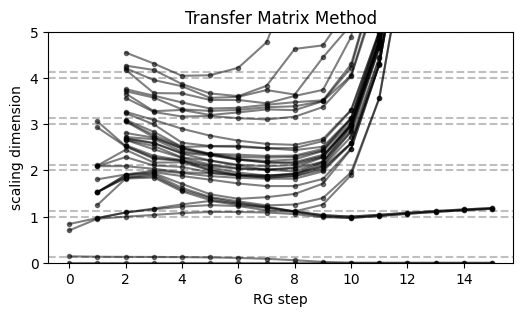

In [9]:
### Transfer Matrix Method
# To wrap a rectangle of aspect ratio m x 1 around a circle, 
#   the inner radius is 1, thus the inner circumference is 2π/m
#   the outer radius is e^(2π/m)
#   eigval[i] = eigval[0] scale^-scdim
#   scdim[i] = -log(eigval[i]/eigval[0])/(2π/m)

def get_scdim_TM(T):
    input_dim=T.shape[0]
    TT=contract('aAxy,bByx->abAB',T,T).reshape(input_dim**2,input_dim**2)
    eigval=torch.linalg.svdvals(TT)
    scdim=-torch.log(eigval/eigval[0])/(2*np.pi/2)
    return scdim

scdims=[get_scdim_TM(T) for T in Ts]

show_ising_scdim(scdims,'Transfer Matrix Method')


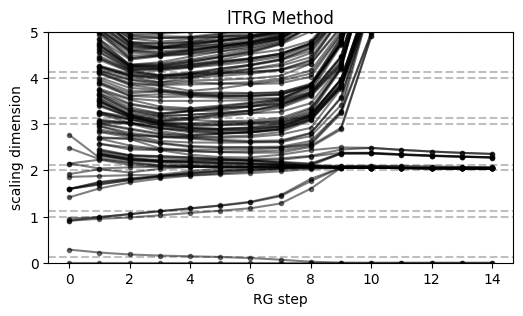

In [10]:
### lTRG Method
# This time the scaling is 2

def get_scdim_lTRG(T,w1,w2):
    input_shape=T.shape
    def forward(T):
        T=T.reshape(input_shape)
        T=forward_HOTRG(T,T,w1)
        T=forward_HOTRG(T,T,w2)
        return T.flatten()
    M=torch.autograd.functional.jacobian(forward,T.flatten())
    eigval=torch.linalg.svdvals(M)
    scdim=-torch.log(eigval/eigval[0])/np.log(2)
    return scdim

scdims=[get_scdim_lTRG(T,*w) for T,w in zip(Ts,ws)]

show_ising_scdim(scdims,'lTRG Method')